# Downloader for Earthquake Catalog Data

This notebook downloads **verified earthquake events** from the USGS/IRIS earthquake catalog and creates a properly labeled training dataset using Raspberry Shake stations in the Anchorage, Alaska region.

## New additions

The previous labeling approach used **rule-based classification** on a single 30-minute window. This notebook instead:

1. Downloads **verified earthquakes** from seismological catalogs (ground truth labels)
2. Gets waveforms from **multiple stations** and **multiple events**
3. Labels windows based on **known earthquake arrival times**
4. Creates a more diverse and reliable training dataset

## Output

- `catalog_waveforms_*.npy` - Labeled waveform windows
- `catalog_labels_*.npy` - Ground truth labels (0=Noise, 2=Earthquake)
- `catalog_metadata_*.csv` - Event info, station, times

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import os
from pathlib import Path
import time
warnings.filterwarnings('ignore')

# ObsPy imports
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

# Set up plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## Configuration

Adjust these parameters to control the earthquake search and data collection.

In [2]:
# =============================================================================
# CONFIGURATION - Adjust these parameters as needed
# =============================================================================

# Geographic region: Anchorage, Alaska area
REGION = {
    'name': 'Anchorage, Alaska',
    'min_lat': 60.0,
    'max_lat': 62.5,
    'min_lon': -151.5,
    'max_lon': -148.5,
    'center_lat': 61.2,
    'center_lon': -149.9
}

# Time range for earthquake search
START_DATE = "2023-01-01"  # Start of search period
END_DATE = "2025-12-01"    # End of search period

# Earthquake magnitude range
MIN_MAGNITUDE = 2.5  # Minimum magnitude (smaller = more events but weaker signal)
MAX_MAGNITUDE = 7.0  # Maximum magnitude

# Station search parameters
MAX_STATION_DISTANCE_KM = 150  # Maximum distance from earthquake to station
MAX_STATIONS_PER_EVENT = 5    # Limit stations per event to avoid redundancy

# Waveform parameters
TIME_BEFORE_EVENT = 30   # Seconds before earthquake origin to download
TIME_AFTER_EVENT = 120   # Seconds after earthquake origin to download
SAMPLING_RATE = 100      # Target sampling rate (Hz)

# Window parameters (must match model)
WINDOW_LENGTH_SEC = 5.0  # 5-second windows
WINDOW_OVERLAP = 0.5     # 50% overlap

# How many events to process (set higher for full dataset)
MAX_EVENTS = 50  # Start with 50, increase for larger dataset

# Output directory
OUTPUT_DIR = Path("labeled_data")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Configuration:")
print(f"  Region: {REGION['name']}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Magnitude range: M{MIN_MAGNITUDE} - M{MAX_MAGNITUDE}")
print(f"  Max station distance: {MAX_STATION_DISTANCE_KM} km")
print(f"  Window length: {WINDOW_LENGTH_SEC} sec")
print(f"  Max events to process: {MAX_EVENTS}")

Configuration:
  Region: Anchorage, Alaska
  Date range: 2023-01-01 to 2025-12-01
  Magnitude range: M2.5 - M7.0
  Max station distance: 150 km
  Window length: 5.0 sec
  Max events to process: 50


## Initialize FDSN Clients

We need two clients:
- **IRIS** for earthquake catalog (verified events with origin times, magnitudes, locations)
- **Raspberry Shake** for waveform data from citizen science seismometers

In [3]:
# Initialize FDSN clients
print("Initializing FDSN clients...")

# IRIS client for earthquake catalog (verified events)
iris_client = Client("IRIS")
print("  ✓ IRIS client (earthquake catalog)")

# Raspberry Shake client for waveforms
rs_client = Client(base_url='https://data.raspberryshake.org')
print("  ✓ Raspberry Shake client (waveforms)")

print("\n✓ Clients initialized successfully!")

Initializing FDSN clients...
  ✓ IRIS client (earthquake catalog)
  ✓ Raspberry Shake client (waveforms)

✓ Clients initialized successfully!


## Search for Earthquakes in the Region

Query the IRIS earthquake catalog for verified events in the Anchorage area.

In [4]:
print(f"Searching for earthquakes M{MIN_MAGNITUDE}+ in {REGION['name']}...")
print(f"Date range: {START_DATE} to {END_DATE}")

try:
    catalog = iris_client.get_events(
        starttime=UTCDateTime(START_DATE),
        endtime=UTCDateTime(END_DATE),
        minlatitude=REGION['min_lat'],
        maxlatitude=REGION['max_lat'],
        minlongitude=REGION['min_lon'],
        maxlongitude=REGION['max_lon'],
        minmagnitude=MIN_MAGNITUDE,
        maxmagnitude=MAX_MAGNITUDE,
        orderby="time"
    )
    
    print(f"\n✓ Found {len(catalog)} earthquakes!")
    
except Exception as e:
    print(f"Error searching catalog: {e}")
    catalog = None

Searching for earthquakes M2.5+ in Anchorage, Alaska...
Date range: 2023-01-01 to 2025-12-01

✓ Found 707 earthquakes!


In [5]:
# Display earthquake catalog
if catalog and len(catalog) > 0:
    print(f"\nEarthquake Catalog Summary:")
    print("=" * 80)
    
    events_data = []
    for i, event in enumerate(catalog):
        origin = event.preferred_origin() or event.origins[0]
        magnitude = event.preferred_magnitude() or event.magnitudes[0]
        
        events_data.append({
            'event_id': str(event.resource_id).split('/')[-1],
            'time': origin.time,
            'latitude': origin.latitude,
            'longitude': origin.longitude,
            'depth_km': origin.depth / 1000 if origin.depth else None,
            'magnitude': magnitude.mag,
            'mag_type': magnitude.magnitude_type
        })
        
        if i < 20:  # Show first 20
            print(f"{i+1:3d}. M{magnitude.mag:.1f} | {origin.time.strftime('%Y-%m-%d %H:%M:%S')} | "
                  f"{origin.latitude:.2f}°N, {origin.longitude:.2f}°W | Depth: {origin.depth/1000:.1f} km")
    
    if len(catalog) > 20:
        print(f"... and {len(catalog) - 20} more events")
    
    # Convert to DataFrame
    events_df = pd.DataFrame(events_data)
    
    print(f"\nMagnitude distribution:")
    print(f"  Min: M{events_df['magnitude'].min():.1f}")
    print(f"  Max: M{events_df['magnitude'].max():.1f}")
    print(f"  Mean: M{events_df['magnitude'].mean():.1f}")
    print(f"  Median: M{events_df['magnitude'].median():.1f}")
else:
    print("No earthquakes found. Try adjusting search parameters.")
    events_df = pd.DataFrame()


Earthquake Catalog Summary:
  1. M2.9 | 2025-11-30 22:06:04 | 60.65°N, -150.84°W | Depth: 44.5 km
  2. M2.9 | 2025-11-29 13:56:09 | 60.12°N, -151.19°W | Depth: 55.1 km
  3. M3.2 | 2025-11-28 17:32:31 | 61.59°N, -150.75°W | Depth: 71.9 km
  4. M3.3 | 2025-11-28 05:26:08 | 62.43°N, -150.36°W | Depth: 57.7 km
  5. M2.6 | 2025-11-28 03:17:51 | 61.44°N, -151.30°W | Depth: 88.2 km
  6. M3.2 | 2025-11-27 17:41:13 | 61.61°N, -150.52°W | Depth: 47.9 km
  7. M2.6 | 2025-11-27 17:20:06 | 61.66°N, -150.68°W | Depth: 66.0 km
  8. M2.9 | 2025-11-27 17:18:54 | 61.65°N, -150.82°W | Depth: 77.1 km
  9. M6.0 | 2025-11-27 17:11:29 | 61.57°N, -150.75°W | Depth: 69.4 km
 10. M5.6 | 2025-11-27 17:11:28 | 61.61°N, -150.74°W | Depth: 70.4 km
 11. M2.8 | 2025-11-25 23:52:16 | 60.57°N, -151.06°W | Depth: 55.2 km
 12. M2.6 | 2025-11-25 13:49:45 | 61.63°N, -150.45°W | Depth: 44.3 km
 13. M2.9 | 2025-11-25 12:00:43 | 62.09°N, -149.50°W | Depth: 16.7 km
 14. M2.9 | 2025-11-25 07:44:00 | 61.25°N, -150.19°W | Depth:

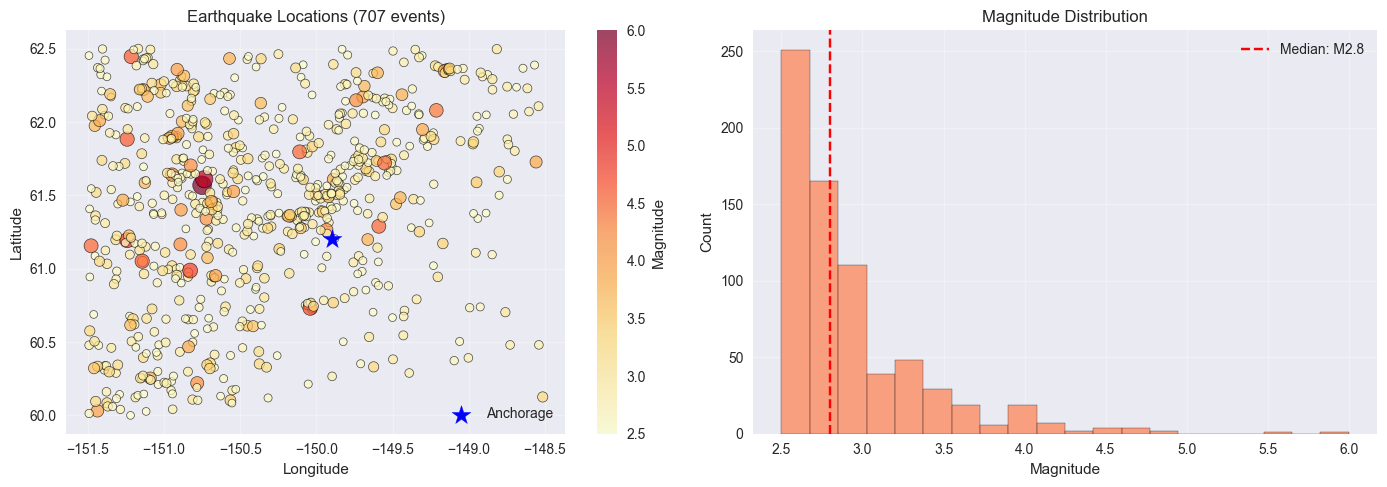

✓ Earthquake visualization complete


In [6]:
# Visualize earthquake locations and magnitudes
if len(events_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Map of earthquakes
    ax1 = axes[0]
    scatter = ax1.scatter(
        events_df['longitude'], 
        events_df['latitude'],
        c=events_df['magnitude'],
        s=events_df['magnitude']**2 * 5,  # Size by magnitude
        cmap='YlOrRd',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    ax1.scatter(REGION['center_lon'], REGION['center_lat'], 
               marker='*', s=200, c='blue', label='Anchorage')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'Earthquake Locations ({len(events_df)} events)')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Magnitude')
    ax1.grid(True, alpha=0.3)
    
    # Magnitude histogram
    ax2 = axes[1]
    ax2.hist(events_df['magnitude'], bins=20, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Magnitude')
    ax2.set_ylabel('Count')
    ax2.set_title('Magnitude Distribution')
    ax2.axvline(events_df['magnitude'].median(), color='red', 
                linestyle='--', label=f'Median: M{events_df["magnitude"].median():.1f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Earthquake visualization complete")

## Find Raspberry Shake Stations

Get available citizen science seismometers in the region.

In [7]:
print("Searching for Raspberry Shake stations in the region...")

try:
    # Get stations for the time range of our events
    station_inventory = rs_client.get_stations(
        network="AM",
        minlatitude=REGION['min_lat'] - 0.5,
        maxlatitude=REGION['max_lat'] + 0.5,
        minlongitude=REGION['min_lon'] - 0.5,
        maxlongitude=REGION['max_lon'] + 0.5,
        starttime=UTCDateTime(START_DATE),
        endtime=UTCDateTime(END_DATE),
        level="station"
    )
    
    # Extract station info
    stations_data = []
    for network in station_inventory:
        for station in network:
            stations_data.append({
                'network': network.code,
                'station': station.code,
                'latitude': station.latitude,
                'longitude': station.longitude,
                'elevation': station.elevation
            })
    
    stations_df = pd.DataFrame(stations_data)
    print(f"\n✓ Found {len(stations_df)} Raspberry Shake stations!")
    
    # Show first few
    print(f"\nSample stations:")
    print(stations_df.head(10).to_string(index=False))
    
except Exception as e:
    print(f"Error getting stations: {e}")
    stations_df = pd.DataFrame()

Searching for Raspberry Shake stations in the region...

✓ Found 73 Raspberry Shake stations!

Sample stations:
network station  latitude   longitude  elevation
     AM   RB38A 61.162162 -149.678492     339.00
     AM   R4017 61.135135 -149.931698      28.00
     AM   R50EC 61.630631 -149.021317     295.00
     AM   R55D5 61.198198 -149.734478      86.00
     AM   R55D5 61.207207 -149.735584      86.00
     AM   RB20A 60.720721 -151.286105      65.00
     AM   RB20A 60.720721 -151.286105      57.63
     AM   SD8CF 61.189189 -149.815443      38.00
     AM   R254E 61.189189 -149.819095      40.00
     AM   R6C15 61.180180 -149.924559      23.00


## Download Waveforms for Each Earthquake

For each earthquake, find nearby stations and download waveforms. Label windows based on:
- **Earthquake (label=2)**: Windows containing the earthquake signal (after P-wave arrival)
- **Noise (label=0)**: Windows before the earthquake arrives (pre-event noise)

In [8]:
# Helper functions
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance in km between two points."""
    dist_m, _, _ = gps2dist_azimuth(lat1, lon1, lat2, lon2)
    return dist_m / 1000  # Convert to km

def estimate_p_arrival(distance_km, depth_km=10):
    """
    Estimate P-wave arrival time in seconds.
    Uses simple approximation: P-wave velocity ~6 km/s in crust.
    """
    # Hypocentral distance
    hypo_dist = np.sqrt(distance_km**2 + depth_km**2)
    # P-wave velocity approximation
    p_velocity = 6.0  # km/s (average crustal P velocity)
    return hypo_dist / p_velocity

def find_nearby_stations(event_lat, event_lon, stations_df, max_distance_km):
    """Find stations within max_distance_km of the event."""
    distances = []
    for _, station in stations_df.iterrows():
        dist = calculate_distance(event_lat, event_lon, 
                                  station['latitude'], station['longitude'])
        distances.append(dist)
    
    result_df = stations_df.copy()
    result_df['distance_km'] = distances
    
    # Filter and sort by distance
    nearby = result_df[result_df['distance_km'] <= max_distance_km]
    nearby = nearby.sort_values('distance_km')
    
    return nearby

print("✓ Helper functions defined")

✓ Helper functions defined


In [9]:
# Main data collection loop
print("=" * 80)
print("DOWNLOADING EARTHQUAKE WAVEFORMS")
print("=" * 80)

# Storage for all windows
all_windows = []
all_labels = []
all_metadata = []

# Windowing parameters
window_samples = int(WINDOW_LENGTH_SEC * SAMPLING_RATE)
step_samples = int(window_samples * (1 - WINDOW_OVERLAP))

# Track statistics
successful_downloads = 0
failed_downloads = 0
total_earthquake_windows = 0
total_noise_windows = 0

# Class names for reference
class_names = {0: 'Noise', 1: 'Traffic', 2: 'Earthquake'}

n_events = min(MAX_EVENTS, len(catalog))
print(f"\nProcessing {n_events} earthquakes...")
print(f"Window size: {window_samples} samples ({WINDOW_LENGTH_SEC}s)")
print(f"Step size: {step_samples} samples")
print("-" * 80)

for event_idx, event in enumerate(catalog[:n_events]):
    # Get event info
    origin = event.preferred_origin() or event.origins[0]
    magnitude = event.preferred_magnitude() or event.magnitudes[0]
    event_time = origin.time
    event_lat = origin.latitude
    event_lon = origin.longitude
    event_depth = origin.depth / 1000 if origin.depth else 10  # km
    event_id = str(event.resource_id).split('/')[-1]
    
    print(f"\n[{event_idx+1}/{n_events}] M{magnitude.mag:.1f} at {event_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Find nearby stations
    nearby_stations = find_nearby_stations(event_lat, event_lon, stations_df, MAX_STATION_DISTANCE_KM)
    
    if len(nearby_stations) == 0:
        print(f"  ⚠ No stations within {MAX_STATION_DISTANCE_KM} km")
        continue
    
    print(f"  Found {len(nearby_stations)} nearby stations")
    
    # Try downloading from nearest stations
    stations_succeeded = 0
    
    for _, station_info in nearby_stations.head(MAX_STATIONS_PER_EVENT).iterrows():
        station_code = station_info['station']
        distance_km = station_info['distance_km']
        
        # Estimate P-wave arrival time
        p_arrival_sec = estimate_p_arrival(distance_km, event_depth)
        
        # Define download window
        download_start = event_time - TIME_BEFORE_EVENT
        download_end = event_time + TIME_AFTER_EVENT
        
        try:
            # Download waveform
            stream = rs_client.get_waveforms(
                network="AM",
                station=station_code,
                location="00",
                channel="EHZ",  # Vertical component
                starttime=download_start,
                endtime=download_end
            )
            
            if len(stream) == 0:
                continue
            
            # Preprocess
            stream.detrend('linear')
            stream.detrend('demean')
            stream.taper(max_percentage=0.05)
            
            # Resample if needed
            if stream[0].stats.sampling_rate != SAMPLING_RATE:
                stream.resample(SAMPLING_RATE)
            
            trace = stream[0]
            data = trace.data
            trace_start = trace.stats.starttime
            
            # Calculate P-wave arrival sample
            p_arrival_sample = int((event_time + p_arrival_sec - trace_start) * SAMPLING_RATE)
            
            # Window the data
            n_samples = len(data)
            event_windows = 0
            noise_windows = 0
            
            for win_start in range(0, n_samples - window_samples, step_samples):
                win_end = win_start + window_samples
                window = data[win_start:win_end]
                
                # Skip if window has issues
                if len(window) != window_samples:
                    continue
                if np.std(window) < 1e-10:  # Dead channel
                    continue
                
                # Normalize window
                window_norm = (window - np.mean(window)) / (np.std(window) + 1e-10)
                
                # Determine label based on P-wave arrival
                # Earthquake: window starts after P-arrival (signal present)
                # Noise: window ends before P-arrival (pre-event noise)
                
                if win_end < p_arrival_sample - int(SAMPLING_RATE):  # 1 sec buffer before P
                    label = 0  # Noise (pre-event)
                    noise_windows += 1
                elif win_start > p_arrival_sample:  # After P-arrival
                    label = 2  # Earthquake
                    event_windows += 1
                else:
                    continue  # Skip windows around P-arrival (ambiguous)
                
                # Store
                all_windows.append(window_norm)
                all_labels.append(label)
                all_metadata.append({
                    'event_id': event_id,
                    'event_time': str(event_time),
                    'magnitude': magnitude.mag,
                    'event_lat': event_lat,
                    'event_lon': event_lon,
                    'event_depth_km': event_depth,
                    'station': station_code,
                    'distance_km': distance_km,
                    'p_arrival_sec': p_arrival_sec,
                    'window_start_sec': win_start / SAMPLING_RATE,
                    'label': label,
                    'label_name': class_names[label]
                })
            
            total_earthquake_windows += event_windows
            total_noise_windows += noise_windows
            stations_succeeded += 1
            successful_downloads += 1
            
            print(f"    ✓ {station_code} ({distance_km:.1f} km): {event_windows} EQ + {noise_windows} noise windows")
            
        except Exception as e:
            failed_downloads += 1
            pass
        
        # Small delay to avoid overwhelming the server
        time.sleep(0.3)
    
    if stations_succeeded == 0:
        print(f"  ⚠ No data available from any station")

print("\n" + "=" * 80)
print("DOWNLOAD COMPLETE")
print("=" * 80)
print(f"\nStatistics:")
print(f"  Successful downloads: {successful_downloads}")
print(f"  Failed downloads: {failed_downloads}")
print(f"  Total earthquake windows: {total_earthquake_windows}")
print(f"  Total noise windows: {total_noise_windows}")
print(f"  Total windows: {len(all_windows)}")

DOWNLOADING EARTHQUAKE WAVEFORMS

Processing 50 earthquakes...
Window size: 500 samples (5.0s)
Step size: 250 samples
--------------------------------------------------------------------------------

[1/50] M2.9 at 2025-11-30 22:06:04
  Found 72 nearby stations
    ✓ R3AF0 (17.9 km): 43 EQ + 13 noise windows
    ✓ RB20A (25.3 km): 43 EQ + 14 noise windows
    ✓ RB20A (25.3 km): 43 EQ + 14 noise windows
    ✓ R9EA1 (72.5 km): 40 EQ + 16 noise windows
    ✓ R4017 (72.9 km): 41 EQ + 16 noise windows

[2/50] M2.9 at 2025-11-29 13:56:09
  Found 59 nearby stations
    ✓ R3AF0 (44.7 km): 42 EQ + 15 noise windows
    ✓ RB20A (66.9 km): 41 EQ + 16 noise windows
    ✓ RB20A (66.9 km): 41 EQ + 16 noise windows
    ✓ R032E (131.2 km): 37 EQ + 20 noise windows

[3/50] M3.2 at 2025-11-28 17:32:31
  Found 71 nearby stations
    ✓ R8A9B (46.9 km): 41 EQ + 16 noise windows
    ✓ R9286 (60.6 km): 40 EQ + 16 noise windows
    ✓ R9286 (60.6 km): 40 EQ + 16 noise windows

[4/50] M3.3 at 2025-11-28 05:26:08

## Visualize Downloaded Data

In [11]:
# Convert to arrays
if len(all_windows) > 0:
    X = np.array(all_windows)
    y = np.array(all_labels)
    metadata_df = pd.DataFrame(all_metadata)
    
    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution:")
    for label, count in zip(unique, counts):
        print(f"  {class_names[label]}: {count} ({count/len(y)*100:.1f}%)")
    
    print(f"\nData diversity:")
    print(f"  Unique earthquakes: {metadata_df['event_id'].nunique()}")
    print(f"  Unique stations: {metadata_df['station'].nunique()}")
    print(f"  Magnitude range: M{metadata_df['magnitude'].min():.1f} - M{metadata_df['magnitude'].max():.1f}")
    print(f"  Distance range: {metadata_df['distance_km'].min():.1f} - {metadata_df['distance_km'].max():.1f} km")
else:
    print("No data collected. Check earthquake catalog and station availability.")

Dataset shape: X=(8255, 500), y=(8255,)

Class distribution:
  Noise: 2208 (26.7%)
  Earthquake: 6047 (73.3%)

Data diversity:
  Unique earthquakes: 48
  Unique stations: 21
  Magnitude range: M2.5 - M6.0
  Distance range: 1.8 - 144.8 km


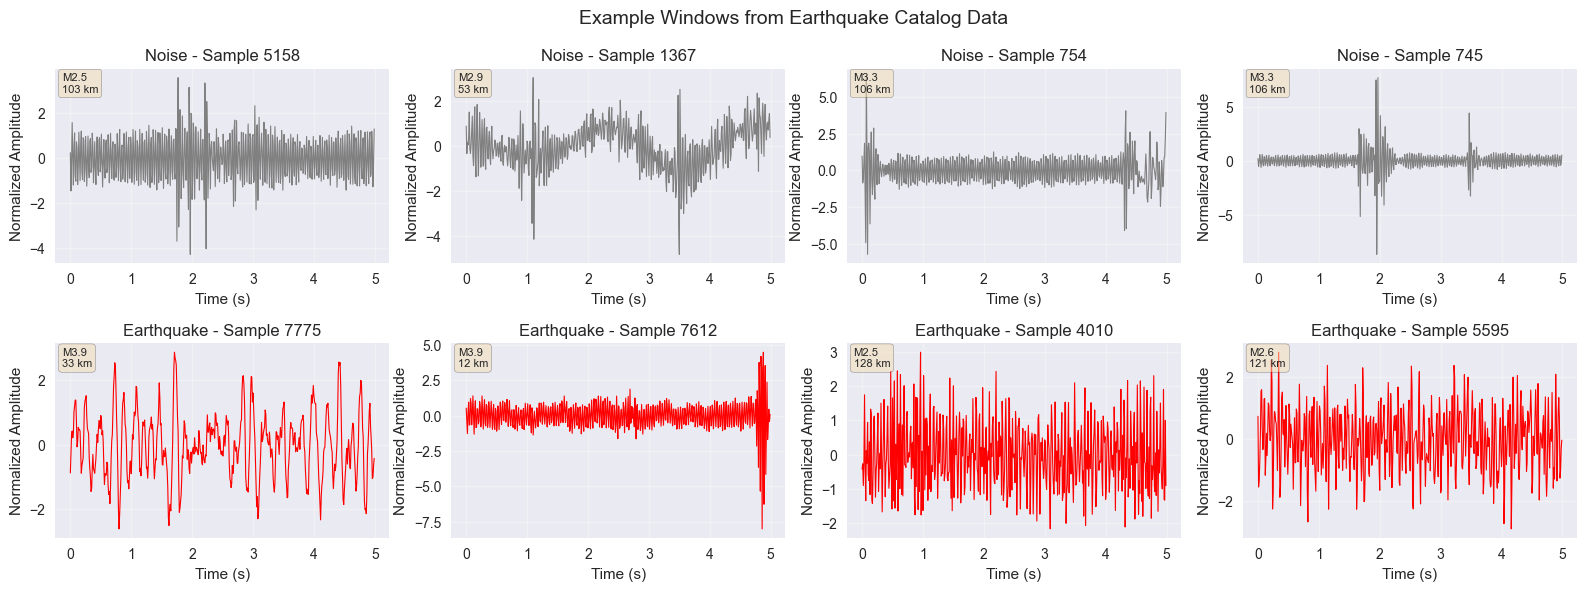

✓ Example windows visualized


In [12]:
# Visualize example windows from each class
if len(all_windows) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    
    time_axis = np.arange(window_samples) / SAMPLING_RATE
    
    for class_label in [0, 2]:  # Noise and Earthquake
        class_name = class_names[class_label]
        class_indices = np.where(y == class_label)[0]
        
        if len(class_indices) == 0:
            continue
        
        # Show 4 random examples
        n_examples = min(4, len(class_indices))
        example_indices = np.random.choice(class_indices, n_examples, replace=False)
        
        row = 0 if class_label == 0 else 1
        color = 'gray' if class_label == 0 else 'red'
        
        for col, idx in enumerate(example_indices):
            ax = axes[row, col]
            ax.plot(time_axis, X[idx], linewidth=0.8, color=color)
            ax.set_title(f"{class_name} - Sample {idx}")
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Normalized Amplitude')
            ax.grid(True, alpha=0.3)
            
            # Add metadata info
            meta = metadata_df.iloc[idx]
            ax.text(0.02, 0.98, f"M{meta['magnitude']:.1f}\n{meta['distance_km']:.0f} km",
                   transform=ax.transAxes, fontsize=8, va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Example Windows from Earthquake Catalog Data', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Example windows visualized")

## Save the Dataset

In [13]:
if len(all_windows) > 0:
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save waveforms
    waveforms_file = OUTPUT_DIR / f"catalog_waveforms_{timestamp}.npy"
    np.save(waveforms_file, X)
    print(f"✓ Saved waveforms to: {waveforms_file}")
    print(f"  Shape: {X.shape}")
    
    # Save labels
    labels_file = OUTPUT_DIR / f"catalog_labels_{timestamp}.npy"
    np.save(labels_file, y)
    print(f"✓ Saved labels to: {labels_file}")
    
    # Save metadata
    metadata_file = OUTPUT_DIR / f"catalog_metadata_{timestamp}.csv"
    metadata_df.to_csv(metadata_file, index=False)
    print(f"✓ Saved metadata to: {metadata_file}")
    
    # Save summary
    summary_file = OUTPUT_DIR / f"catalog_summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("Earthquake Catalog Dataset Summary\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Search Parameters:\n")
        f.write(f"  Region: {REGION['name']}\n")
        f.write(f"  Date range: {START_DATE} to {END_DATE}\n")
        f.write(f"  Magnitude range: M{MIN_MAGNITUDE} - M{MAX_MAGNITUDE}\n")
        f.write(f"  Max station distance: {MAX_STATION_DISTANCE_KM} km\n\n")
        
        f.write("Dataset Statistics:\n")
        f.write(f"  Total earthquakes processed: {n_events}\n")
        f.write(f"  Total windows: {len(X)}\n")
        f.write(f"  Window length: {WINDOW_LENGTH_SEC} seconds\n")
        f.write(f"  Sampling rate: {SAMPLING_RATE} Hz\n\n")
        
        f.write("Class Distribution:\n")
        for label, count in zip(unique, counts):
            f.write(f"  {class_names[label]}: {count} ({count/len(y)*100:.1f}%)\n")
        
        f.write(f"\nUnique events: {metadata_df['event_id'].nunique()}\n")
        f.write(f"Unique stations: {metadata_df['station'].nunique()}\n")
    
    print(f"✓ Saved summary to: {summary_file}")
    
    print("\n" + "=" * 60)
    print("DATASET SAVED SUCCESSFULLY!")
    print("=" * 60)
    print(f"\nTo load this dataset for training:")
    print(f"  X = np.load('{waveforms_file}')")
    print(f"  y = np.load('{labels_file}')")
    print(f"  metadata = pd.read_csv('{metadata_file}')")
else:
    print("No data to save.")

✓ Saved waveforms to: labeled_data/catalog_waveforms_20260202_001311.npy
  Shape: (8255, 500)
✓ Saved labels to: labeled_data/catalog_labels_20260202_001311.npy
✓ Saved metadata to: labeled_data/catalog_metadata_20260202_001311.csv
✓ Saved summary to: labeled_data/catalog_summary_20260202_001311.txt

DATASET SAVED SUCCESSFULLY!

To load this dataset for training:
  X = np.load('labeled_data/catalog_waveforms_20260202_001311.npy')
  y = np.load('labeled_data/catalog_labels_20260202_001311.npy')
  metadata = pd.read_csv('labeled_data/catalog_metadata_20260202_001311.csv')


## Next Steps

Now that you have real earthquake catalog data:

1. **Train the model**: Use `notebooks/03_training/train_cnn_multiclass.ipynb` with this dataset
2. **Compare results**: See if performance improves with verified ground truth labels
3. **Expand dataset**: Increase `MAX_EVENTS` or extend date range for more data
4. **Add traffic class**: Traffic signals aren't in earthquake catalogs - need separate data source (rule-based from urban stations)

In [14]:
print("\n🎉 Notebook complete!")
print("\nDataset summary:")
if len(all_windows) > 0:
    print(f"  • {len(X)} total windows")
    print(f"  • {(y == 2).sum()} earthquake windows")
    print(f"  • {(y == 0).sum()} noise windows")
    print(f"  • From {metadata_df['event_id'].nunique()} unique earthquakes")
    print(f"  • Recorded at {metadata_df['station'].nunique()} different stations")
else:
    print("  No data collected - check configuration and try again.")


🎉 Notebook complete!

Dataset summary:
  • 8255 total windows
  • 6047 earthquake windows
  • 2208 noise windows
  • From 48 unique earthquakes
  • Recorded at 21 different stations
